# Judging
The process of judging these models involved running a number of different classifiers with a gridsearch to determine the best hyperparamaters for each classifier.
After the best hyperparamaters were chosen, the different classifiers were sorted by their recall score and that is how they are displayed in the summary table and
confusion matrices block.

Recall was chosen at the metric of highest concern as it represents the actual proportion of positives in the models prediction. We operate under the assumption that
allowing fraudulent transactions through is more costly than falsely flagging transactions as fraudulent when they are not.

Having said that, recall was not the only metric considered. Precision was also weighed against the recall. While it is assumed that it is more expensive to miss a fraudulent trasaction, it does not mean that any number of false positives is too high. For the final recommendation, both of these were held in consideration.

# Recommendation

## 1. Random Forest Classifier

The model that is chosen as the highest performing model is random forest. Its summary line is as follows

    Random Forest 30I: F1-Score: 40.171	Recall: 71.646	Precision: 27.91

While it does not have the highes recall score, it is somewhat balanced in comparison to other classifiers used. Balancing the accuracy of predicting fraud and limiting the number of falsely flagging transactions.

## 2. Decision Tree

This model is chosen second as it appears to find a middle ground in both its recall and precision:

    Decision TreeI: F1-Score: 54.062	Recall: 55.793	Precision: 52.436

This model allows more fraudulent transactions throught than the random forest, however it does prevent the number of false positives from being raised.

## 3. Gradient Boosting

Gradient boosting comes in last. This is somewhat surprising considering that it does have the highest recall of any model tested.

    Gradient BoostingI: F1-Score: 2.618	Recall: 92.988	Precision: 1.328

Having said that, it's precision comes through at 1.328. Meaning that is is flagging a substantial number of transactions as fraudulent when they actually are not. While it is great that so many fraudulent are caught, the number of false flags is seen to be unacceptable. After analyzing the true cost of each of these errors, the ranking my change, however under the assumptions at the time of writing, this appears to be the best model.

In [689]:
import polars as pl
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import hashlib
from joblib import dump, load
import json

from datetime import datetime

In [690]:
# Pulling in original data source file reference
orig_data_file = pathlib.Path("./data/mis501_fraud.csv")

In [691]:
# Pulling in with polars to improve data processing speed
polars_fraud_df = pl.read_csv(orig_data_file)

# While reading in data, convert date data over to date
polars_fraud_df = polars_fraud_df.with_columns([
    pl.col("date_of_birth").str.strptime(pl.Date, "%d/%m/%Y"),
    pl.col("transaction_timestamp").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M")
])

In [692]:
# Get the current year to use when calculating cardholders age
current_year = pl.lit(datetime.now().year)

# We want to derive useful data from these dates that our classifier can use
polars_fraud_df = polars_fraud_df.with_columns([
    # We want to get the hour that a transaction occurred
    polars_fraud_df["transaction_timestamp"].dt.hour().alias("transaction_hour"),
    # We want the day of the week that the transaction occured
    polars_fraud_df["transaction_timestamp"].dt.weekday().alias("transaction_day"),
    # We want the age of each cardholder
    (current_year - polars_fraud_df["date_of_birth"].dt.year()).alias("cardholder_age") 
])

In [693]:
# Convert gender data to numerical values
polars_fraud_df = polars_fraud_df.with_columns([
    pl.when(pl.col('gender') == "M").then(1).otherwise(0).alias('gender_encoded')
])

In [694]:
# I pulled this straight from chat
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    # Haversine formula
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c  # in kilometers
    
    return distance

In [695]:
# Apply the Haversine function to calculate distances between cardholder coordinates and transaction coordinates
polars_fraud_df = polars_fraud_df.with_columns(
    pl.apply(
        [pl.col("lat"), pl.col("long"), pl.col("merch_lat"), pl.col("merch_long")],
        lambda cols: haversine(cols[0], cols[1], cols[2], cols[3])
    ).alias("distance_km")
)


/tmp/ipykernel_6573/1705835225.py:3: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_groups`.
  pl.apply(


In [696]:
# Column to be targeted
target = "is_fraud"

# Grabbing all columns that are numerical
numerical_features = ['amount', 'city_pop', 'transaction_hour', 'transaction_day', 'cardholder_age', 'distance_km', 'gender_encoded']

# Grabbing all columns that represent categorical data
categorical_features= ["category", "job_title"]

# Combining features together 
all_features = numerical_features + categorical_features

In [697]:
# We only want to retain the columns that will be used in the classifier
polars_fraud_df = polars_fraud_df[[target] + numerical_features]

In [698]:
# Create file path
dummified_file_name = "./data/dummified-data.csv"
polars_fraud_df.write_csv(dummified_file_name)

In [699]:
dum_data_file = pathlib.Path(dummified_file_name)

fraud_df = pd.read_csv(dum_data_file)

fraud_df

,is_fraud,amount,city_pop,transaction_hour,transaction_day,cardholder_age,distance_km,gender_encoded
0,0,1.07,5438,7,7,60,66.563673,0
1,0,94.99,7163,14,7,42,85.415937,1
2,0,31.28,602,16,1,70,16.266628,0
3,0,73.06,7163,10,6,42,110.434216,1
4,0,9.99,2036,1,1,53,72.330958,0
...,...,...,...,...,...,...,...,...
416784,0,80.93,3688,12,6,51,44.248096,1
416785,0,102.42,54287,9,6,52,132.483211,0
416786,0,84.52,7297,23,4,34,91.293779,1
416787,0,244.65,51,14,4,64,52.277209,0


In [700]:
X_train, X_test, y_train, y_test = train_test_split(
    fraud_df[numerical_features],
    fraud_df[target],
    # Splitting the data so that we are training on 80% of data provided
    test_size=.2,
    random_state=42,
    # We want to ensure that we have an even pulling of both the fraud and non fraud data
    stratify=fraud_df[target]
)

In [701]:
def hash_dictionary(d):
    # Sort the dictionary by key to ensure consistent ordering
    serialized = json.dumps(d, sort_keys=True)
    # Create a hash object
    hash_object = hashlib.sha256(serialized.encode())
    # Return the hexadecimal digest of the hash
    return hash_object.hexdigest()

In [702]:
# Create list of different classifiers for training
base_clfs = [
    {
        "title": "Decision TreeI",
        "clf": DecisionTreeClassifier(random_state=42),
        "features": all_features,
        "params": {
            # Gridsearch narrowed down to entropy for the criterion 
            "criterion": ['entropy'],
            # Although this splitter is computationally more expensive it leads to better results
            'splitter': ['best'],
            # When specifying other max features, performance of the classifier decreased.
            # By allowing the classifier to all features at each split, superior results were achieved
            'max_features': [None],
            # Although other classifiers performed better when changing the 1 to a higher number, this one
            # did not. Gridsearch found that this configuration yielded better results
            'class_weight': [{0:1, 1: 1}]
        }
    },
    {
        "title": "Gradient BoostingI",
        "clf": GradientBoostingClassifier(random_state=42),
        "features": all_features,
        "params": {
            # We set this estimator to a number of 500 so that the highest number of errors possible is caught
            # Originally this value was closer to 100, but it have been increased drastically to improve performance
            "n_estimators": [500],
            # This number originally started off at .1, it is set
            # to 8. By increasing this number to 8, the overall impact of each tree has been reduced. When this number was lower, the model
            # Was hardly able to predeict any fraudulent transactions
            "learning_rate": [8, 16],
            # Using exponential because we want the model to be more sensitive to mis-classifications.
            "loss": ["exponential"],
            # Using this becuse it is specifically designed for gradient boosting
            "criterion": ['friedman_mse'],
            # Using none since there is a relatively low number of features that are used
            "max_features": [None]
        },
    },
    {
        "title": "Random Forest 30I",
        "clf": RandomForestClassifier(random_state=42),
        "features": all_features,
        "params": {
            # We left this at 100, in order ensure that the model would remain general and open to future test data
            "n_estimators": [100],
            # In order to prevent overfitting, max_depth was set to 5 to prevent the number of layers from going to far
            "max_depth": [5],
            # We want to penalize false negatives so we set 1 to 30 to ensure that we are properly incentivizing the model
            "class_weight": [{0: 1, 1: 30}]
        }
    },
]

# Function to pull in cached classifier
def load_clf(file_hash: str):
    try:
        return load(f"./clfs/{file_hash}.joblib")
    except:
        return None

# Function to cache classifier
def save_clf(file_name: str, clf: GridSearchCV):
    dump(clf, f"./clfs/{file_name}.joblib")


# Function to pass each classifier into, in order to perform grid search on it
def run_gridsearch(base_clf: dict):
    # retrieve the params to be used for GridSearch
    params = base_clf['params']

    min_base_clf = base_clf.copy()
    # Remove the clf for hashing purposed
    del min_base_clf['clf']
    
    # Hash the params to create unique file id
    min_base_clf_hash = hash_dictionary(min_base_clf)

    # Attempt to load the clf if params have not changed
    clf = load_clf(min_base_clf_hash)

    # Dumpt the clf to a file to save time for future testing
    if clf == None:

        # Instantiate the GridSearch object
        clf = GridSearchCV(base_clf['clf'], param_grid=params, n_jobs=6, scoring="recall", verbose=3)
        
        # fit the model
        clf = clf.fit(X_train, y_train)

        # dump  the model to the file for caching
        save_clf(min_base_clf_hash, clf)

    # return necessary data for future processing
    return {
        "clf": clf,
        "title": base_clf['title']
    }


# Train each classifier specified
trained_clfs = [run_gridsearch(base_clf) for base_clf in base_clfs]

In [703]:
# Displays each classifiers best hyper paramaters 
for trained_clf in trained_clfs:
    print(f"{trained_clf['title']} {trained_clf['clf'].best_params_}")

Decision TreeI {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}
Gradient BoostingI {'criterion': 'friedman_mse', 'learning_rate': 8, 'loss': 'exponential', 'max_features': None, 'n_estimators': 500}
Random Forest 30I {'class_weight': {0: 1, 1: 30}, 'max_depth': 5, 'n_estimators': 100}


In [704]:
def gather_classification_results(trained_clf: GridSearchCV, data: pd.DataFrame):
    title = trained_clf['title']
    clf = trained_clf['clf']

    # Calculate training and testing scores
    training_score = clf.score(X_train, y_train)
    testing_score = clf.score(X_test, y_test)

    # Make predictions on the test data
    predictions = clf.predict(X_test)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = (predictions == y_test).mean()
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    f1 = f1_score(y_test, predictions, average='binary')

    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()

    # Calculate the false negative and false positive rates
    false_negative_rate = fn / (fn + tp) * 100
    false_positive_rate = fp / (fp + tn) * 100

   # Calculate fraud_pred_accuracy, i.e., recall or true positive rate
    fraud_pred_accuracy = tp / (tp + fn) * 100

    return {
        "title": title,
        "training_score": training_score * 100,
        "testing_score": testing_score * 100,
        "accuracy": accuracy * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1_score": f1 * 100,
        "false_negative_rate": false_negative_rate,
        "false_positive_rate": false_positive_rate,
        "fraud_pred_accuracy": fraud_pred_accuracy,
        "matrix": [[tn, fp], [fn, tp]],
        "clf": clf
    }

# Classification Summary Table

In [705]:
# Gather array of performance results for each classifier
results = [gather_classification_results(trained_clf, fraud_df.copy()) for trained_clf in trained_clfs]
# Sort the results by the highest recall
sorted_results = list(sorted(results, key=lambda x: x['recall'], reverse=True))

# Dispaly all the classifiers and key metrics
for result in sorted_results:
    print(f"{result['title']}: F1-Score: {round(result['f1_score'], 3)}\tRecall: {round(result['recall'], 3)}\tPrecision: {round(result['precision'], 3)}")

Gradient BoostingI: F1-Score: 2.618	Recall: 92.988	Precision: 1.328
Random Forest 30I: F1-Score: 40.171	Recall: 71.646	Precision: 27.91
Decision TreeI: F1-Score: 54.062	Recall: 55.793	Precision: 52.436


# Confusion Matrices

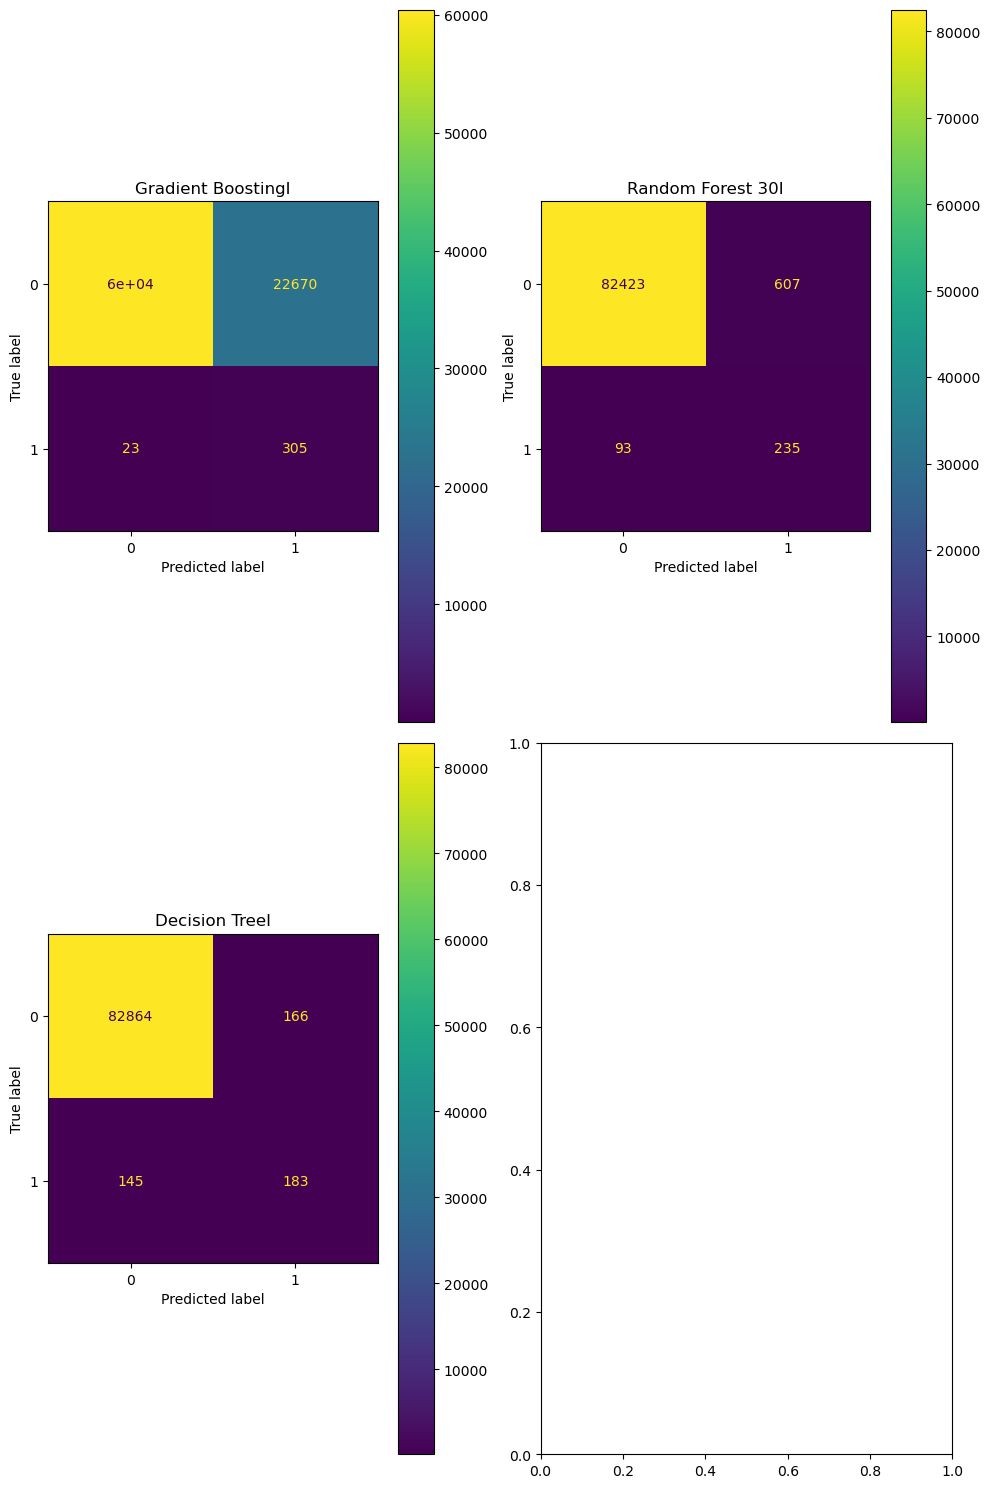

In [706]:
# Generate list of models to be used for displaying
models = list(map(lambda x: [x['clf'], x['title']], sorted_results))

# Get only the models
model_list = list(map(lambda x: x[0], models))

# Get each models associated title
titles = list(map(lambda x: x[1], models))

fig, axes = plt.subplots(2, 2, figsize=(10, 15))
axes = axes.flatten()

for ax, model, title in zip(axes, model_list, titles):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test, 
        y_test,
        ax=ax,
        cmap='viridis'  # Optional: choose a colormap
    )
    ax.title.set_text(title)  # Set the title for each subplot

plt.tight_layout()
plt.show()